In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler

import os

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


Главные параметры для извлечения удара сердца.

In [3]:
BEAT_LENGTH = 600 
ECG_CHANNEL = 1

In [4]:

gts = pd.read_csv("./train/train_gts.csv")
meta = pd.read_csv("./train/train_meta.csv")

df = meta.merge(gts, on='record_name', )
df

,ecg_id,patient_id,age,sex,height,weight,nurse,site,device,recording_date,...,burst_noise,electrodes_problems,extra_beats,pacemaker,strat_fold,filename_lr,filename_hr,record_name,group,myocard
0,9,18792.0,55.0,0,NaN,70.0,2.0,0.0,CS-12 E,1984-12-08 09:44:43,...,NaN,NaN,NaN,NaN,10,records100/00000/00009_lr,records500/00000/00009_hr,00009_hr,1,0
1,34,13619.0,56.0,0,NaN,NaN,2.0,0.0,CS-12 E,1985-02-10 12:04:03,...,NaN,NaN,NaN,NaN,9,records100/00000/00034_lr,records500/00000/00034_hr,00034_hr,3,0
2,43,11315.0,25.0,1,NaN,63.0,2.0,0.0,CS-12 E,1985-03-14 09:38:53,...,NaN,NaN,NaN,NaN,8,records100/00000/00043_lr,records500/00000/00043_hr,00043_hr,3,0
3,52,18153.0,35.0,0,NaN,82.0,2.0,0.0,CS-12 E,1985-05-18 08:15:54,...,NaN,NaN,NaN,NaN,1,records100/00000/00052_lr,records500/00000/00052_hr,00052_hr,2,0
4,57,16063.0,26.0,0,NaN,93.0,2.0,0.0,CS-12 E,1985-06-06 11:32:43,...,NaN,NaN,NaN,NaN,10,records100/00000/00057_lr,records500/00000/00057_hr,00057_hr,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2096,21784,12488.0,66.0,1,NaN,NaN,0.0,0.0,CS100 3,2001-01-29 11:46:31,...,NaN,NaN,NaN,NaN,1,records100/21000/21784_lr,records500/21000/21784_hr,21784_hr,3,0
2097,21795,10162.0,68.0,0,NaN,NaN,1.0,2.0,AT-60 3,2001-01-31 17:30:42,...,NaN,NaN,NaN,NaN,4,records100/21000/21795_lr,records500/21000/21795_hr,21795_hr,3,0
2098,21825,11197.0,59.0,0,NaN,NaN,1.0,2.0,AT-60 3,2001-05-12 11:07:26,...,NaN,NaN,NaN,NaN,3,records100/21000/21825_lr,records500/21000/21825_hr,21825_hr,1,0
2099,21831,11905.0,55.0,1,NaN,NaN,1.0,2.0,AT-60 3,2001-05-28 12:49:25,...,NaN,NaN,NaN,NaN,9,records100/21000/21831_lr,records500/21000/21831_hr,21831_hr,3,0


In [5]:
df_test = pd.read_csv("./test/test_meta.csv")
df_test

,ecg_id,patient_id,age,sex,height,weight,nurse,site,device,recording_date,...,static_noise,burst_noise,electrodes_problems,extra_beats,pacemaker,strat_fold,filename_lr,filename_hr,record_name,group
0,127,11926.0,22.0,1,NaN,52.0,0.0,0.0,CS-12 E,1986-01-30 13:10:31,...,", I-AVR,",NaN,NaN,NaN,NaN,9,records100/00000/00127_lr,records500/00000/00127_hr,00127_hr,1
1,186,12396.0,60.0,1,NaN,NaN,NaN,3.0,AT-6 C,1986-03-19 14:07:42,...,NaN,NaN,NaN,NaN,NaN,9,records100/00000/00186_lr,records500/00000/00186_hr,00186_hr,2
2,193,17536.0,28.0,0,NaN,112.0,0.0,0.0,CS-12 E,1986-03-22 09:24:13,...,NaN,NaN,NaN,NaN,NaN,9,records100/00000/00193_lr,records500/00000/00193_hr,00193_hr,1
3,198,21074.0,19.0,1,NaN,59.0,0.0,0.0,CS-12 E,1986-04-18 10:52:02,...,NaN,NaN,NaN,NaN,NaN,9,records100/00000/00198_lr,records500/00000/00198_hr,00198_hr,2
4,211,18690.0,85.0,1,NaN,NaN,1.0,2.0,CS-12,1986-05-19 10:15:08,...,", leicht,",NaN,NaN,NaN,NaN,3,records100/00000/00211_lr,records500/00000/00211_hr,00211_hr,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
444,21269,8951.0,44.0,0,NaN,NaN,1.0,2.0,CS-12,2000-08-15 13:20:54,...,NaN,NaN,NaN,NaN,NaN,1,records100/21000/21269_lr,records500/21000/21269_hr,21269_hr,1
445,21301,21392.0,71.0,0,NaN,NaN,0.0,0.0,CS100 3,2000-08-27 09:26:21,...,", I-AVF,",NaN,NaN,NaN,NaN,4,records100/21000/21301_lr,records500/21000/21301_hr,21301_hr,2
446,21366,17212.0,62.0,1,NaN,NaN,0.0,0.0,CS100 3,2000-09-18 09:06:20,...,NaN,NaN,NaN,NaN,NaN,2,records100/21000/21366_lr,records500/21000/21366_hr,21366_hr,1
447,21547,13332.0,40.0,0,NaN,NaN,0.0,0.0,CS100 3,2000-11-11 17:01:21,...,NaN,AVL,NaN,NaN,NaN,2,records100/21000/21547_lr,records500/21000/21547_hr,21547_hr,1


In [6]:
def load_record(record_name, is_train):
    if is_train:
        with open(f"./train/{record_name}.npy", "rb") as f:
            data  = np.load(f, allow_pickle=True)
    else:
        with open(f"./test/{record_name}.npy", "rb") as f:
            data  = np.load(f, allow_pickle=True)
    return data

def print_beat(x, y, ecg_channel):
    fig, ax = plt.subplots()  # Create a figure containing a single axes.
    ax.set_title(f"ECG channel {ecg_channel}")
    ax.plot(x, y)  # Plot some data on the axes.

Повторяю препроцессинг  из папиры[https://arxiv.org/pdf/1806.00794.pdf] для получения экг одного удара сердца

The steps used for extracting beats
from an ECG signal are as follows (see Fig. 1):
1) Splitting the continuous ECG signal to 10s windows and
select a 10s window from an ECG signal.
2) Normalizing the amplitude values to the range of be-
tween zero and one.
3) Finding the set of all local maximums based on zero-
crossings of the first derivative.
4) Finding the set of ECG R-peak candidates by applying
a threshold of 0.9 on the normalized value of the local
maximums.
5) Finding the median of R-R time intervals as the nominal
heartbeat period of that window (T ).
6) For each R-peak, selecting a signal part with the length
equal to 1.2T .
7) Padding each selected part with zeros to make its length
equal to a predefined fixed length.

In [7]:
#TODO: 
# 1. получения удара сердца хорошо работает не со всеми каналами
# 2. нужно или почистить изначальные данные или поменять алгоритм      
def extract_beat(record, to_print=False, ecg_channel=-1, BEAT_LENGTH=750, T_MULTIPLICATOR=1.2):
    """
        Extracts singular beats from single ecg_channel

        -----
        record_name - name from train_meta.csv
        ecg_channel - one of 12 possible ecg channels
        BEAT_LENGTH - predefined length, used for padding
        T_MULTIPLICATOR - used in original paper 
    """
    data = record[ecg_channel]
    data = data.reshape(-1,1) # reshaping for sklearn

    # normalize between 0 and 1
    data_norm = MinMaxScaler((0,1)).fit_transform(data).flatten()
    data = data.flatten()

    # find set of local maxima
    def find_local_maxima(arr):
        diff = np.diff(arr)  # Calculate the first derivative
        sign_changes = np.sign(diff)  # Analyze the sign changes
        #[3,2,1,-1,-2] - diff
        #[1,1,1,-1,-1] - sign_changes
        #[0, 0, -2, 0] - zero_crossings
        zero_crossings = np.diff(sign_changes)  # Find the zero-crossings

        indicies = (zero_crossings==-2).nonzero()[0] + 1 # we add 1, as diff skips first element
        return indicies

    maxima_inds = find_local_maxima(data_norm)
    maxima_vals = data_norm[maxima_inds]

    #get only those maximums, which value > 0.9 
    indicies_filtered = maxima_inds[(maxima_vals>0.9).nonzero()[0]] 
    if(len(indicies_filtered)==0):
        raise ValueError
    T = np.median(np.diff(indicies_filtered)) #  median time between beats
    T *= T_MULTIPLICATOR
    T = int(T) 

    if T>3000:
        raise ValueError
    beats = [] 
    for R_peak in indicies_filtered:
        if(R_peak+T>len(data_norm)):
            continue
        beat = data_norm[R_peak: R_peak+T]
        
        if(len(beat)>=BEAT_LENGTH):
            beat = beat[:BEAT_LENGTH]
        else:
            padding_zeros = np.array([0 for _ in range(BEAT_LENGTH-len(beat))])
            beat = np.hstack((beat, padding_zeros)) 
        
        beats.append(beat)
    
    if(len(beats)==0):
        raise ValueError 

    # choose the center beat 
    beats.sort(key = lambda x: len(x))
    #result_beat = beats[len(beats)//2] if(len(beats)>1) else beats[0]
    result_beat = beats[1] if(len(beats)>1) else beats[0]


    if to_print:
        print_beat([x for x in range(BEAT_LENGTH)], result_beat, ecg_channel)

    return np.array(result_beat)

Пытаюсь понять какой BEAT LENGTH выбрать
выбрал 600


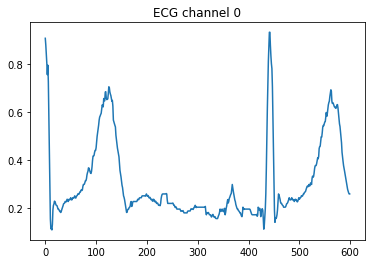

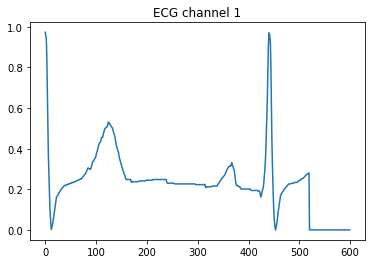

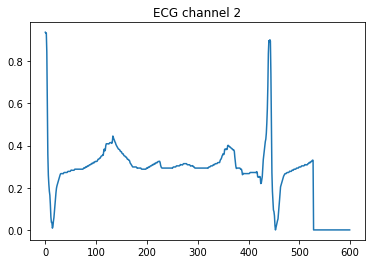

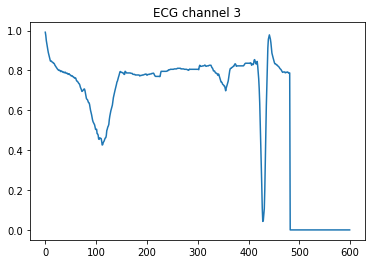

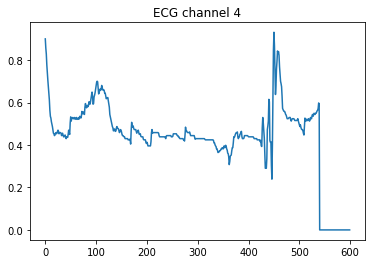

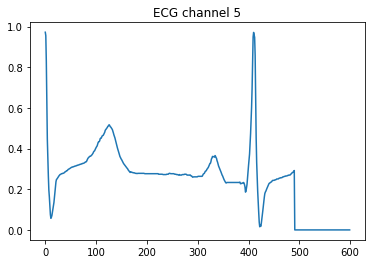

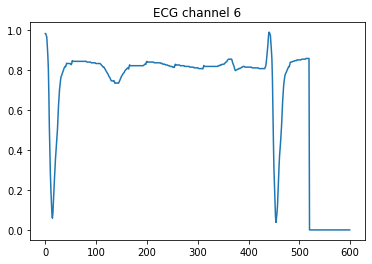

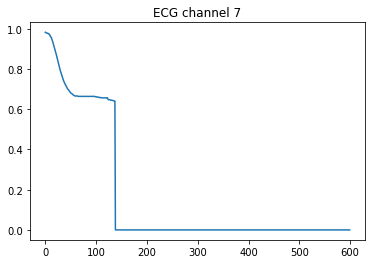

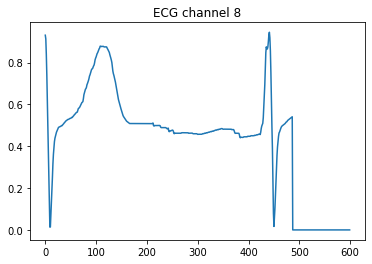

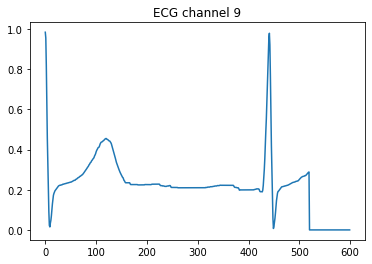

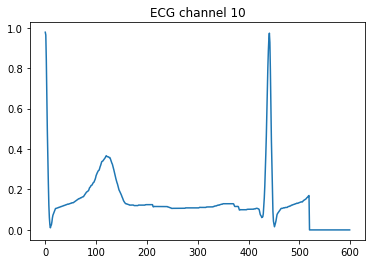

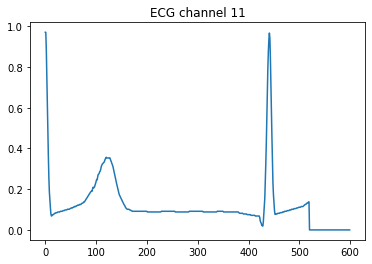

In [8]:
test_record_name = "00061_hr"
ecg = load_record(record_name=test_record_name, is_train=True)
for lead in range(12):
    beat = extract_beat(ecg, to_print=True, ecg_channel=lead, BEAT_LENGTH=BEAT_LENGTH)


In [9]:


def pipeline(df, is_train):
    """
    1. Extracts one beat from the last channel of ecg files 
    2. Saves these beats as a new file
    """
    
    record_names = df['record_name'].to_list()

    result_df = df
    result_df['correct_transformation'] = True # sometimes beat extraction doesn't work 
    for record_name in record_names:
        beats = []
        try:
            record = load_record(record_name, is_train=is_train)
            for channel in range(12):
                extracted_beat = extract_beat(record, to_print=False, ecg_channel=channel, BEAT_LENGTH=BEAT_LENGTH)
                beats.append(extracted_beat)
        except ValueError:
            result_df.loc[result_df['record_name']==record_name, 'correct_transformation'] = False
            continue
         
        if is_train: 
            if(not os.path.exists("./transformed_train/")):
                os.mkdir("./transformed_train/")
            np.save(f"./transformed_train/{record_name}.npy", beats) 
        else:
            if(not os.path.exists("./transformed_test/")):
                os.mkdir("./transformed_test/")
            np.save(f"./transformed_test/{record_name}.npy", beats) 

    return result_df

In [10]:
from sklearn.preprocessing import Normalizer

def pipeline_annotations(df, is_train):

    
    ## Очень много столбцов, где заполнено меньше 1% значений, 
    ## поэтому я решил соединить их в "суперклассы", которые находятся в scp_statements.csv
    
    # expand dicts into separate columns
    scp_codes = df['scp_codes'].map(eval).apply(pd.Series)
    scp_codes.merge
    print(len(scp_codes.columns))
    # percentage of non nan values
    print((scp_codes.notna().sum()/len(scp_codes)).sort_values(ascending=False).iloc[:15])
    (scp_codes.notna().sum()).sort_values(ascending=False).iloc[:15]   

    ## Все столбцы, где нет значения 'diagnostic class' - это abnormalities(так написано в столбце 'description')

    scp_codes_description = pd.read_csv('./scp_statements.csv')
    scp_codes_description = scp_codes_description.rename(columns={'Unnamed: 0': 'code'})

    print("количество кодов",len(scp_codes_description))
    superclasses = scp_codes_description\
        .groupby('diagnostic_class')['code'].unique().to_dict()
    # these are codes for different abnormalities
    abnormalities = scp_codes_description['code']\
        [scp_codes_description['diagnostic_class'].isna()].values
    superclasses['abnormalities'] = abnormalities
    print("словарь суперклассов",superclasses)

    for superclass, columns in superclasses.items():
        columns = [col.strip() for col in columns]

        for code in columns:
            if code not in scp_codes.columns:
                columns.remove(code)

        scp_codes[superclass] = scp_codes[columns].sum(axis=1)
        scp_codes=scp_codes.drop(columns=columns)

    superclasses["NORM"] = []

    df = df.merge(scp_codes, left_index=True, right_index=True)

    ## Это написано в ридми датасета 
    ## Records in fold 9 and 10 underwent at least one human evaluation and are therefore of a particularly high label quality.
    ## We therefore propose to use folds 1-8 as training set, fold 9 as validation set and fold 10 as test set.


    # normalize values
    values = df[['CD', "HYP", "MI", "STTC", 'abnormalities']].values 
    df[['CD', "HYP", "MI", "STTC", 'abnormalities']] = Normalizer().fit_transform(values)

    ## убираем строки, где некорректно прошло извлечение бита из экг
    annotations = df[df['correct_transformation']==True] 

    annotations = annotations[['record_name', 'strat_fold','myocard']]   


    val_annotations = annotations[annotations['strat_fold'].isin([8, 9, 10])]
    train_annotations = annotations[annotations['strat_fold'].isin(range(1,8))]
    val_annotations.to_csv('./val_annotations.csv', index=False)
    train_annotations.to_csv('./train_annotations.csv', index=False)

    print("validation percentage:",len(val_annotations) / len(annotations))
    print("train percentage:",len(train_annotations) / len(annotations))
    print("VALIDATION", val_annotations["myocard"].value_counts(normalize=True))
    print("TTRAIN", train_annotations["myocard"].value_counts(normalize=True))


In [11]:
res_df_train = pipeline(df, True)
pipeline_annotations(res_df_train, True)

/mnt/sda5/conda/envs/open-mmlab/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/mnt/sda5/conda/envs/open-mmlab/lib/python3.8/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/mnt/sda5/conda/envs/open-mmlab/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/mnt/sda5/conda/envs/open-mmlab/lib/python3.8/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/mnt/sda5/conda/envs/open-mmlab/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/mnt/sda5/conda/envs/open-mmlab/lib/python3.8/site-packages/numpy/core/_methods.py:190: Ru

KeyboardInterrupt: 

In [ ]:
res_df_test = pipeline(df_test, False)
#pipeline_annotations(res_df_test, False)

/mnt/sda5/conda/envs/open-mmlab/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/mnt/sda5/conda/envs/open-mmlab/lib/python3.8/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/mnt/sda5/conda/envs/open-mmlab/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/mnt/sda5/conda/envs/open-mmlab/lib/python3.8/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/mnt/sda5/conda/envs/open-mmlab/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/mnt/sda5/conda/envs/open-mmlab/lib/python3.8/site-packages/numpy/core/_methods.py:190: Ru

In [ ]:
res_df_train['correct_transformation'].value_counts()

True     1420
False     681
Name: correct_transformation, dtype: int64

In [ ]:
res_df_test['correct_transformation'].value_counts()

True     286
False    163
Name: correct_transformation, dtype: int64